# CS229, Fall 2017
## Problem Set 2: Supervised Learning II

This is my solutions for CS229 - Fall 2017: Machine Learning taught by Andrew Ng.

The material for Problem Set 2 is here: [ps2](https://github.com/nmduonggg/ML-CS229/blob/master/Problem%20Set%202/ps2.pdf)

This notebook contains the solution for __Question 6: Spam Classification__

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Question 6.a)

#### Naive Bayes

In [2]:
def readMatrix(file):
    fd = open(file, 'r')
    hdr = fd.readline()
    rows, cols = [int(s) for s in fd.readline().strip().split()]
    tokens = fd.readline().strip().split()
    matrix = np.zeros((rows, cols))
    Y = []
    for i, line in enumerate(fd):
        nums = [int(x) for x in line.strip().split()]
        Y.append(nums[0])
        kv = np.array(nums[1:])
        k = np.cumsum(kv[:-1:2])
        v = kv[1::2]
        matrix[i, k] = v
    return matrix, tokens, np.array(Y)

def nb_train(matrix, category):
    state = {}
    N = matrix.shape[1]
    ###################
    spam = matrix[category == 1, :]
    nonspam = matrix[category == 0, :]

    phi_y1 = (np.sum(spam, axis = 0) + 1) / (spam.sum() + N)
    phi_y0 = (np.sum(nonspam, axis = 0) + 1) / (nonspam.sum() + N)
    phi_y = spam.shape[0] / matrix.shape[0]

    state['phi_y1'] = phi_y1    # prob that jth token appears given y=1
    state['phi_y0'] = phi_y0    # prob that jth token appears given y=1
    state['phi_y'] = phi_y

    ###################
    return state

def nb_test(matrix, state):
    output = np.zeros(matrix.shape[0])
    ###################

    phi_y1 = state['phi_y1']
    phi_y0 = state['phi_y0']
    phi_y = state['phi_y']

    log_probSpam = np.sum(np.log(phi_y1)*matrix, axis = 1) + np.log(phi_y)
    log_probNon = np.sum(np.log(phi_y0)*matrix, axis = 1) + np.log(phi_y)

    output[log_probSpam >= log_probNon] = 1
    ###################
    return output

def evaluate(output, label):
    error = (output != label).sum() * 1. / len(output)
    print('Error: %1.4f' % error)
    return error


trainMatrix, tokenlist, trainCategory = readMatrix('./data/MATRIX.TRAIN.txt')
testMatrix, tokenlist, testCategory = readMatrix('./data/MATRIX.TEST.txt')

state = nb_train(trainMatrix, trainCategory)
output = nb_test(testMatrix, state)

evaluate(output, testCategory)


Error: 0.0163


0.01625

### Question 6.b)

In [3]:
phi_y1 = state['phi_y1']
phi_y0 = state['phi_y0']

intuitiveSpam = np.log(phi_y1 / phi_y0)
indices_token = np.argsort(-intuitiveSpam)[:5] # negate to get the descending order

In [4]:
indices_token

array([ 615, 1209, 1356,  393, 1368], dtype=int64)

In [5]:
np.array(tokenlist)[indices_token]

array(['httpaddr', 'spam', 'unsubscrib', 'ebai', 'valet'], dtype='<U16')

### Question 6.c)

In [6]:
def repeat_nb(trainFile, train_size):
    trainMatrix, tokenlist, trainCategory = readMatrix(trainFile)
    testMatrix, tokenlist, testCategory = readMatrix('./data/MATRIX.TEST.txt')

    state = nb_train(trainMatrix, trainCategory)
    output = nb_test(testMatrix, state)

    test_err = evaluate(output, testCategory)
    return (train_size, test_err)

In [7]:
samples = [('./data/MATRIX.TRAIN.50.txt', 50),
           ('./data/MATRIX.TRAIN.100.txt', 100),
           ('./data/MATRIX.TRAIN.200.txt', 200),
           ('./data/MATRIX.TRAIN.400.txt', 400),
           ('./data/MATRIX.TRAIN.800.txt', 800),
           ('./data/MATRIX.TRAIN.1400.txt.', 1400)]

In [8]:
num_samp = len(samples)
train_sizes = np.zeros(num_samp)
test_errors = np.zeros(num_samp)
for i in range(num_samp):
    trainFile, train_size = samples[i]
    train_sizes[i], test_errors[i] = repeat_nb(trainFile, train_size)
    
test_errors

Error: 0.0400
Error: 0.0262
Error: 0.0262
Error: 0.0187
Error: 0.0175
Error: 0.0163


array([0.04   , 0.02625, 0.02625, 0.01875, 0.0175 , 0.01625])

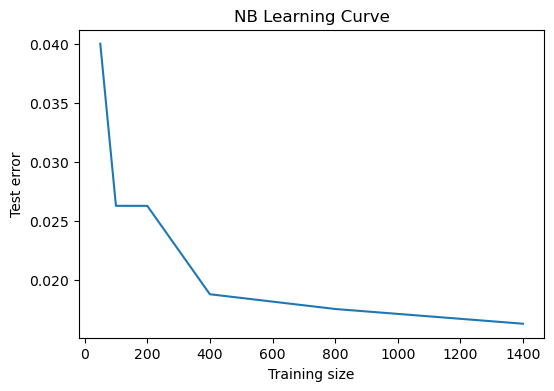

In [9]:
plt.figure(figsize = (6, 4))
plt.plot(train_sizes, test_errors)
plt.title("NB Learning Curve")
plt.xlabel("Training size")
plt.ylabel("Test error")

plt.show()

__Review__: Training test with 1400 of size seems to give the best test error

### Question 6.d)

#### SVM

In [10]:
import numpy as np

tau = 8.

def readMatrix(file):
    fd = open(file, 'r')
    hdr = fd.readline()
    rows, cols = [int(s) for s in fd.readline().strip().split()]
    tokens = fd.readline().strip().split()
    matrix = np.zeros((rows, cols))
    Y = []
    for i, line in enumerate(fd):
        nums = [int(x) for x in line.strip().split()]
        Y.append(nums[0])
        kv = np.array(nums[1:])
        k = np.cumsum(kv[:-1:2])
        v = kv[1::2]
        matrix[i, k] = v
    category = (np.array(Y) * 2) - 1
    return matrix, tokens, category

def svm_train(matrix, category):
    state = {}
    M, N = matrix.shape
    #####################
    Y = category
    matrix = 1. * (matrix > 0)
    squared = np.sum(matrix * matrix, axis=1)
    gram = matrix.dot(matrix.T)
    K = np.exp(-(squared.reshape((1, -1)) + squared.reshape((-1, 1)) - 2 * gram) / (2 * (tau ** 2)) )

    alpha = np.zeros(M)
    alpha_avg = np.zeros(M)
    L = 1. / (64 * M)
    outer_loops = 40

    alpha_avg
    for ii in range(outer_loops * M):
        i = int(np.random.rand() * M)
        margin = Y[i] * np.dot(K[i, :], alpha)
        grad = M * L * K[:, i] * alpha[i]
        if (margin < 1):
            grad -=  Y[i] * K[:, i]
        alpha -=  grad / np.sqrt(ii + 1)
        alpha_avg += alpha

    alpha_avg /= (ii + 1) * M

    state['alpha'] = alpha
    state['alpha_avg'] = alpha_avg
    state['Xtrain'] = matrix
    state['Sqtrain'] = squared
    ####################
    return state

def svm_test(matrix, state):
    M, N = matrix.shape
    output = np.zeros(M)
    ###################
    Xtrain = state['Xtrain']
    Sqtrain = state['Sqtrain']
    matrix = 1. * (matrix > 0)
    squared = np.sum(matrix * matrix, axis=1)
    gram = matrix.dot(Xtrain.T)
    K = np.exp(-(squared.reshape((-1, 1)) + Sqtrain.reshape((1, -1)) - 2 * gram) / (2 * (tau ** 2)))
    alpha_avg = state['alpha_avg']
    preds = K.dot(alpha_avg)
    output = np.sign(preds)
    ###################
    return output

def evaluate(output, label):
    error = (output != label).sum() * 1. / len(output)
    print('Error: %1.4f' % error)
    return error

def main():
    trainMatrix, tokenlist, trainCategory = readMatrix('./data/MATRIX.TRAIN.400.txt')
    testMatrix, tokenlist, testCategory = readMatrix('./data/MATRIX.TEST.txt')

    state = svm_train(trainMatrix, trainCategory)
    output = svm_test(testMatrix, state)

    evaluate(output, testCategory)
    return

main()

Error: 0.0025


In [11]:
def repeat_svm(trainFile, train_size):
    trainMatrix, tokenlist, trainCategory = readMatrix(trainFile)
    testMatrix, tokenlist, testCategory = readMatrix('./data/MATRIX.TEST.txt')

    state = svm_train(trainMatrix, trainCategory)
    output = svm_test(testMatrix, state)

    test_err = evaluate(output, testCategory)
    return (train_size, test_err)

num_samp = len(samples)
train_sizes = np.zeros(num_samp)
test_errors = np.zeros(num_samp)
for i in range(num_samp):
    trainFile, train_size = samples[i]
    train_sizes[i], test_errors[i] = repeat_svm(trainFile, train_size)
    
test_errors

Error: 0.0213
Error: 0.0225
Error: 0.0037
Error: 0.0013
Error: 0.0000
Error: 0.0000


array([0.02125, 0.0225 , 0.00375, 0.00125, 0.     , 0.     ])

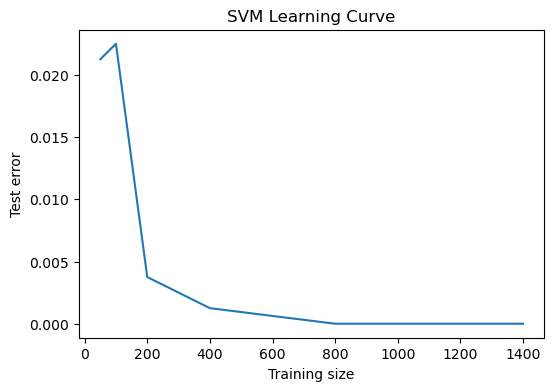

In [12]:
plt.figure(figsize = (6, 4))
plt.plot(train_sizes, test_errors)
plt.title("SVM Learning Curve")
plt.xlabel("Training size")
plt.ylabel("Test error")

plt.show()

### Question 6.e)

Both NB and SVM decrease gradually, but SVM seems to better at generalization error term. SVM find an optimal decison boundary that can reach 0.00 (perfectly correct) with the large dataset.